# Knowledge distillation and Topic modelling
---
On today's meeting, we're going to implement the distillation process in Keras and evaluate it on IMDB dataset (movie reviews with the sentiment: positive or negative, assigned).

The general idea of knowledge distillation is to teach a smaller model mimic the behaviour of the larger one. Here, we will teach a smaller model to provide the same probability distribution as the teacher, where those probability distrubutions come from the outputs of the teacher (after `softmax`). If we succeed, we have a smaller model (faster, requiring less memory) that has similar output quality!

We will use Keras here, as it is a simple framework that provides a high level API to create neural networks.

In this task, we're going to create a RNN-based student model. However, please remember that we have also many pre-trained distilled models based on transformer that are available on HuggingFace model hub, e.g.: [distilBERT]((https://huggingface.co/distilbert-base-uncased), [distilRoBERTa](https://huggingface.co/distilroberta-base), [distilGPT2](https://huggingface.co/distilgpt2), and many more.

This code is based on the notebook you can find here: https://github.com/Ankur3107/nlp_notebooks/tree/master/knowledge-distillation


---
**Done by:** Sofya Aksenyuk, 150284

---

In [1]:
# import tensorflow, Keras is available from within it
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers  # Layers used to compose the network

In [2]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review

(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)

print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")

# Ensure that each example is of the same length. Those longer than 200 are truncated, those shorter are padded with a special [PAD] token
# We need equal lenghts inside a given batch, to process several examples at once so some quick heruistics is to simply make every examle of equal length
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

17464789/17464789 [==============================] - 1s 0us/step
25000 Training sequences
25000 Validation sequences


In [3]:
# This is the Distiller class we discussed in our lecture. 
# This class takes two models in its constructor: a teacher (which is already trained), and a student (which may contain some random variables -- we'll train it to mimic the teacher)

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        # Take a student model and a teacher model and store inside the object
        super(Distiller, self).__init__()
        self.teacher = student
        self.student = teacher

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Make a train step ;)
        # 1. load a given batch of data
        # 2. Make predictions
        # 3. Calculate the loss
        # 4. backpropagate
        # 5. report metrics
        
        
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Make a test step
        # 1. load a given batch
        # 2. make a prediction
        # 3. store predictions
        # 4. evaluate the model

        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

Then, let's define the architectures of both the student and the teacher

In [4]:
# Create the teacher
# Input for variable-length sequences of integers
inputs = keras.Input(shape=(maxlen,), dtype="int32")
# Embed each integer (representing a position of a given token in the vocabulary [one-hot-encoding!]) in a 128-dimensional vector
x = layers.Embedding(vocab_size, 128)(inputs)
# Add 2 bidirectional LSTMs and GRUs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(128))(x)
# Add a classifier
outputs = layers.Dense(2)(x)
teacher = keras.Model(inputs, outputs, name='teacher')
teacher.summary()


# Create the student
# Input for variable-length sequences of integers
inputs = keras.Input(shape=(maxlen,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(vocab_size, 64)(inputs)
# Add 2 bidirectional LSTMs and GRUs
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(32))(x)
# Add a classifier
outputs = layers.Dense(2)(x)
student = keras.Model(inputs, outputs, name='student')
student.summary()

Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          2560000   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 128)         98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              198144    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 2)                 514       
                                                                 
Total params: 2,857,474
Trainable params: 2,857,474
Non-tra

After these steps, we can train the teacher from scratch to make it able to assign sentiment to reviews

In [5]:
# Train teacher as usual
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate teacher on data.
teacher.fit(x_train, y_train, epochs=3)
teacher.evaluate(x_val, y_val)

Epoch 1/3
782/782 [==============================] - 100s 112ms/step - loss: 0.3776 - sparse_categorical_accuracy: 0.8309
Epoch 2/3
782/782 [==============================] - 34s 44ms/step - loss: 0.2021 - sparse_categorical_accuracy: 0.9237
Epoch 3/3
782/782 [==============================] - 11s 13ms/step - loss: 0.3850 - sparse_categorical_accuracy: 0.8540


[0.3850458860397339, 0.8539999723434448]

Having a teacher, let's distill knowledge from it!

In [6]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
distiller.fit(x_train, y_train, epochs=3)

# Evaluate student on test dataset
distiller.evaluate(x_val, y_val)

Epoch 1/3
782/782 [==============================] - 88s 100ms/step - sparse_categorical_accuracy: 0.9694 - student_loss: 0.1314 - distillation_loss: 0.0084
Epoch 2/3
782/782 [==============================] - 38s 49ms/step - sparse_categorical_accuracy: 0.9825 - student_loss: 0.1046 - distillation_loss: 0.0087
Epoch 3/3
782/782 [==============================] - 11s 13ms/step - sparse_categorical_accuracy: 0.8485 - student_loss: 0.3924


[0.8484799861907959, 0.31112489104270935]

Great! We distilled knowledge from our teacher!

---

#Topic modeling

The second area we're going to focus in is the task of topic modeling. Our course was dominated by the supervised learning, where we had labels we learned to predict. However, there are some situations where we have a bunch of documents without the labels and our goal is to explore the dataset and search for some clusters of elements that are more similar to each other.

The task of topic modeling focuses on extracting topics from our documents. Maybe the dataset of e-mails we have represent mostly three topics, such as politics, sport, and offers? Topic modeling can help us in this area by creating clusters of related words. As we have no labels assigned, the topics extracted cannot be named with a nice label. Instead, we have sets of words related to topics identified and our role is to "name" those lists (e.g., the topic related to `sport` may contain words like `goal`, `match`, `ball`, `score`, etc.). 

There are many classical approaches, as the task of topic modeling is much older than the transformer-based revolution. However, today we will focus on a novel, BERT-based approach called BERTopic.

Some other, classical approaches are: 
- [LDA](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf): Latent Dirichlet Allocation (not Linear Discriminant Analysis -- these share the same LDA abbreviation but are different things!)
- [LSA](https://people.duke.edu/~ccc14/bios-823-2018/Z05_SVD.html): Latent Semantic Analysis

A good comparison of various topic modeling approaches can be found [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9120935/).

## Task:
In this part of our meeting, we will iterate over two tutorials, that describe how we can use BERTopic on a given dataset. The first one is a short and general one, and the second one dives much deepeer into internals of this model. 

Your task is to follow those tutorials and copy-and-paste the code fragments here so that we can observe the outputs.

**The first tutorial we'll use is available here**: [Tutorial1](https://maartengr.github.io/BERTopic/index.html)
Copy-and-paste the fragments of code below to observe the results:

In [7]:
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 97.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 82.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   

In [8]:
!pip install bertopic[flair]
!pip install bertopic[gensim]
!pip install bertopic[spacy]
!pip install bertopic[use]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.1/373.1 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 kB 47.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 31.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 48.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 36.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.2
    Uninstalling protobuf-3.20.2:
      Successfully uninstalled protobuf-3.20.2


In [9]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups

docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)

In [10]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,6247,-1_to_the_is_of
1,0,1828,0_game_team_games_he
2,1,590,1_key_clipper_chip_encryption
3,2,525,2_ites_cheek_yep_huh
4,3,464,3_fbi_batf_fire_koresh
...,...,...,...
210,209,10,209_tires_tire_fluids_brake
211,210,10,210_plutonium_nuclear_reactors_bomb
212,211,10,211_amd_486_intel_chips
213,212,10,212_needles_acupuncture_needle_syringe


In [11]:
topic_model.get_topic(0)

[('game', 0.010450482812897184),
 ('team', 0.009096071007927375),
 ('games', 0.007252457706595171),
 ('he', 0.007135084265521841),
 ('players', 0.006355911116873157),
 ('season', 0.006298538356748285),
 ('hockey', 0.00616078819019693),
 ('play', 0.005820370583649648),
 ('25', 0.005699993794484428),
 ('year', 0.005666563883763597)]

In [12]:
topic_model.get_document_info(docs)

,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,\n\nI am sure some bashers of Pens fans are pr...,0,0_game_team_games_he,game - team - games - he - players - season - ...,1.000000,False
1,My brother is in the market for a high-perform...,4,4_card_monitor_video_drivers,card - monitor - video - drivers - vga - monit...,1.000000,False
2,\n\n\n\n\tFinally you said what you dream abou...,20,20_armenian_turkish_armenians_genocide,armenian - turkish - armenians - genocide - tu...,0.309519,False
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,36,36_scsi_scsi2_scsi1_ide,scsi - scsi2 - scsi1 - ide - controller - bus ...,0.728106,False
4,1) I have an old Jasmine drive which I cann...,73,73_tape_backup_tapes_drive,tape - backup - tapes - drive - device - munro...,0.635931,False
...,...,...,...,...,...,...
18841,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,15,15_hiv_patients_medical_aids,hiv - patients - medical - aids - disease - 17...,0.996068,False
18842,\nNot in isolated ground recepticles (usually ...,177,177_ground_grounding_conductor_neutral,ground - grounding - conductor - neutral - wir...,0.211221,False
18843,I just installed a DX2-66 CPU in a clone mothe...,87,87_fan_cpu_heat_sink,fan - cpu - heat - sink - fans - cooling - chi...,1.000000,False
18844,\nWouldn't this require a hyper-sphere. In 3-...,22,22_den_polygon_points_algorithm,den - polygon - points - algorithm - xxxx - pl...,1.000000,False


**The first tutorial we'll use is available here**: [Tutorial2](https://www.pinecone.io/learn/bertopic/)

BTW. the website where the second tutorial is published (pinecone.io) is the website of a vector database called `Pinecone`. These databases are used to store vector representation of our documents. As recent NLP-related models are huge neural networks providing embeddings depending on the context, instead of vectorizing a given document multiple times, using, for example `RoBERTa` (which may be costly, because the network is quite large), we can *cache* the vector representation in such a database.


Copy-and-paste the fragments of code below to observe the results:

In [78]:
from datasets import load_dataset

data = load_dataset('jamescalam/reddit-python', split="train")
data = data.filter(
    lambda x: True if len(x['selftext']) > 30 else 0
)

In [79]:
data

Dataset({
    features: ['sub', 'title', 'selftext', 'upvote_ratio', 'id', 'created_utc'],
    num_rows: 622
})

In [80]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# we add this to remove stopwords
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

# deal with df if needed
if type(data['selftext']) is list:
    text = data['selftext']
else:
    text = data['selftext'].tolist()

model = BERTopic(
    vectorizer_model=vectorizer_model,
    language='english', calculate_probabilities=True,
    verbose=True
)
topics, probs = model.fit_transform(text)

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

2023-05-21 14:46:02,973 - BERTopic - Transformed documents to Embeddings
2023-05-21 14:46:09,377 - BERTopic - Reduced dimensionality
2023-05-21 14:46:09,434 - BERTopic - Clustered reduced embeddings


In [81]:
freq = model.get_topic_info()
freq.head(10)

,Topic,Count,Name
0,-1,231,-1_python_code_use_data
1,0,71,0_image_ampx200b_video_python
2,1,55,1_python_learning_programming_just
3,2,40,2_django_flask_python_library
4,3,29,3_link_title_thumbnail_datepublished
5,4,28,4_package_python_like_slap
6,5,27,5_quantum_sequence_digit_pi
7,6,26,6_ideas_project ideas_make_comment
8,7,22,7_python_resource_use thread_related
9,8,20,8_type_vf_python_orggre


In [82]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [83]:
import numpy as np
from tqdm.auto import tqdm

batch_size = 16
n = 622
embeds = np.zeros((n, model.get_sentence_embedding_dimension()))

for i in tqdm(range(0, n, batch_size)):
    i_end = min(i+batch_size, n)
    batch = data['selftext'][i:i_end]
    batch_embed = model.encode(batch)
    embeds[i:i_end,:] = batch_embed

  0%|          | 0/39 [00:00<?, ?it/s]

In [84]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [20]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [85]:
import umap

In [86]:
fit = umap.UMAP(n_neighbors=3, n_components=3, min_dist=0.05)
u = fit.fit_transform(embeds)

In [87]:
import hdbscan

clusterer = hdbscan.HDBSCAN()
clusterer.fit(u)

HDBSCAN()

<Axes: ylabel='$\\lambda$ value'>

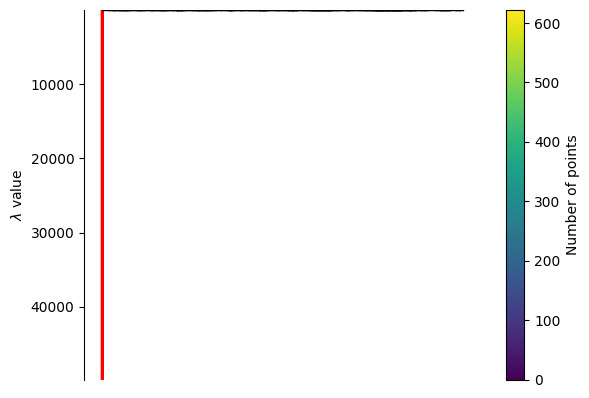

In [88]:
clusterer.condensed_tree_.plot(select_clusters=True)

<Axes: ylabel='$\\lambda$ value'>

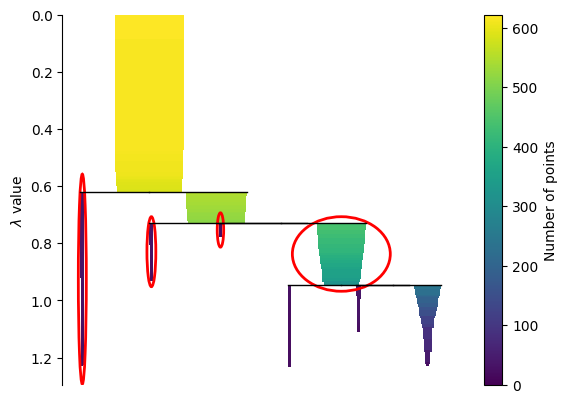

In [89]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=20)
clusterer.fit(u)

clusterer.condensed_tree_.plot(select_clusters=True)

<Axes: ylabel='$\\lambda$ value'>

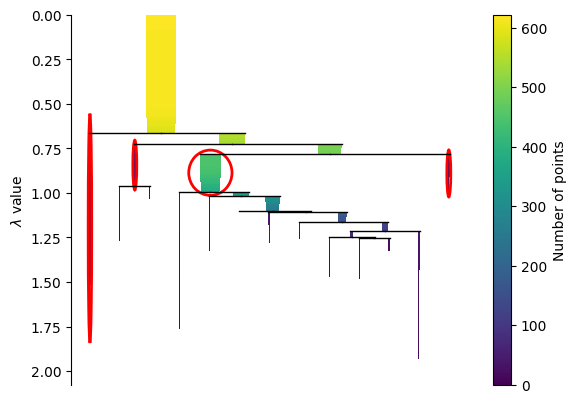

In [90]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15)
clusterer.fit(u)

clusterer.condensed_tree_.plot(select_clusters=True)

<Axes: ylabel='$\\lambda$ value'>

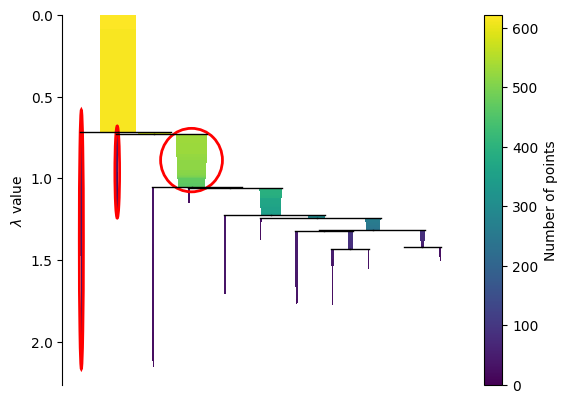

In [91]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=20, min_samples=10)
clusterer.fit(u)

clusterer.condensed_tree_.plot(select_clusters=True)

In [28]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [92]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [95]:
# first lowercase and remove punctuation
alpha = re.compile(r'[^a-zA-Z ]+')
data = data.map(lambda x: {
    'tokens': alpha.sub('', x['selftext']).lower()
})

In [96]:
data[0]

{'sub': 'Python',
 'title': 'Flask -&gt; FastAPI',
 'selftext': "I'm happy with Flask and do not see the need to switch to FastAPI. Change my mind &amp; (ideally) point me to a nice tutorial that does just that in a demo project.",
 'upvote_ratio': 0.25,
 'id': 't3_ubiv0a',
 'created_utc': 1650885862.0,
 'tokens': 'im happy with flask and do not see the need to switch to fastapi change my mind amp ideally point me to a nice tutorial that does just that in a demo project'}

In [97]:
# tokenize, separating by whitespace
data = data.map(lambda x: {
    'tokens': nltk.tokenize.wordpunct_tokenize(x['tokens'])
})

In [98]:
# # remove stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))
# stopwords from nltk are all lowercase (so are our tokens)
data = data.map(lambda x: {
    'tokens': word for word in x['tokens'] if word not in stopwords
})

In [100]:
data = data.add_column('class', clusterer.labels_)

In [42]:
data[3]

{'sub': 'Python',
 'title': 'Monday Daily Thread: Project ideas!',
 'selftext': 'Comment any project ideas beginner or advanced in this thread for others to give a try! If you complete one make sure to reply to the comment with how you found it and attach some source code! If you\'re looking for project ideas, you might be interested in checking out Al Sweigart\'s, ["The Big Book of Small Python Projects"](https://inventwithpython.com/bigbookpython/) which provides a list of projects and the code to make them work.',
 'upvote_ratio': 0.73,
 'id': 't3_ub7ugb',
 'created_utc': 1650844811.0,
 'tokens': 'work'}

In [151]:
# add the cluster labels to our dataset

classes = {label: {'tokens': list()} for label in set(clusterer.labels_)}
# add tokenized sentences to respective class
for row in data:
    classes[row['class']]['tokens'].append(row['tokens'])

In [152]:
for c in classes.keys():
    # stopwords = nltk.corpus.stopwords.words('english')
    # stopwords from nltk are all lowercase (so are our tokens)
    classes[c]['tokens'] = [
        word for word in classes[c]['tokens'] if word not in stopwords
    ]
    print(f"{c}: {len(classes[c]['tokens'])}")

0: 36
1: 41
2: 536
-1: 9


In [153]:
vocab = set()
for c in classes.keys():
    vocab = vocab.union(set(classes[c]['tokens']))
    classes[c]['vocab'] = set(classes[c]['tokens'])

In [154]:
tf = np.zeros((len(classes.keys()), len(vocab)))

for c, _class in enumerate(classes.keys()):
    for t, term in enumerate(tqdm(vocab)):
        tf[c, t] = classes[_class]['tokens'].count(term)
tf

  0%|          | 0/488 [00:00<?, ?it/s]

  0%|          | 0/488 [00:00<?, ?it/s]

  0%|          | 0/488 [00:00<?, ?it/s]

  0%|          | 0/488 [00:00<?, ?it/s]

array([[0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 2.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [155]:
idf = np.zeros((1, len(vocab)))

# calculate average number of words per class
A = tf.sum() / tf.shape[0]

for t, term in enumerate(tqdm(vocab)):
    # frequency of term t across all classes
    f_t = tf[:,t].sum()
    # calculate IDF
    idf_score = np.log(1 + (A / f_t))
    idf[0, t] = idf_score
idf

  0%|          | 0/488 [00:00<?, ?it/s]

array([[5.05305601, 5.05305601, 5.05305601, 5.05305601, 3.9671423 ,
        5.05305601, 5.05305601, 5.05305601, 5.05305601, 3.46885603,
        5.05305601, 5.05305601, 5.05305601, 5.05305601, 5.05305601,
        5.05305601, 5.05305601, 5.05305601, 4.36627828, 5.05305601,
        3.29274567, 5.05305601, 4.36627828, 5.05305601, 5.05305601,
        5.05305601, 5.05305601, 5.05305601, 5.05305601, 5.05305601,
        5.05305601, 5.05305601, 5.05305601, 3.9671423 , 5.05305601,
        5.05305601, 5.05305601, 5.05305601, 5.05305601, 5.05305601,
        5.05305601, 5.05305601, 5.05305601, 5.05305601, 5.05305601,
        5.05305601, 5.05305601, 5.05305601, 5.05305601, 5.05305601,
        5.05305601, 5.05305601, 5.05305601, 5.05305601, 5.05305601,
        5.05305601, 5.05305601, 5.05305601, 5.05305601, 5.05305601,
        5.05305601, 5.05305601, 5.05305601, 3.9671423 , 3.29274567,
        5.05305601, 4.36627828, 5.05305601, 5.05305601, 5.05305601,
        5.05305601, 5.05305601, 2.71710004, 5.05

In [156]:
tf_idf = tf*idf
tf_idf

array([[0.        , 5.05305601, 0.        , ..., 0.        , 5.05305601,
        0.        ],
       [5.05305601, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 5.05305601, ..., 5.05305601, 0.        ,
        8.73255656],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [157]:
n = 5
top_idx = np.argpartition(tf_idf, -n)[:, -n:]
top_idx

array([[208,  40, 276, 387, 380],
       [ 76, 299,  72, 449,   0],
       [353, 149, 337,  79,  64],
       [161, 212, 450,  89, 240]])

In [158]:
vlist = list(vocab)

for c, _class in enumerate(classes.keys()):
    topn_idx = top_idx[c, :]
    topn_terms = [vlist[idx] for idx in topn_idx]
    print(topn_terms)

['apihttpsgithubcomhackernewsapi', 'asciidecodeunicodeescape', 'security', 'browserhttpsgithubcomestarqiemuhttpsgithubcomestarqiemu', 'httpsserpapicomblogscrapenaverrelatedsearchresultswithpython']
['httpswwwyoutubecomchannelucljgzitdkxtowzsakghttpswwwyoutubecomchannelucljgzitdkxtowzsakg', 'though', 'response', 'project', 'linkhttpsprogskillsscomhowtocreateadigitalclockwithpythonhttpsprogskillsscomhowtocreateadigitalclockwithpython']
['sidebar', 'work', 'resources', 'thanks', 'permitted']
['httpsserpapicomblogscrapegooglecarouselresultswithpython', 'purpose', 'printidd', 'nice', 'share']


In [166]:
data = load_dataset(
    'jamescalam/reddit-topics', split='train',
    revision='c14d532'  # this specifies current version of dataset
)
# remove short self text
data = data.filter(lambda x: True if len(x['selftext']) > 30 else 0)
data

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/jamescalam___json/jamescalam--reddit-topics-5426f597ee8d3805/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


Filter:   0%|          | 0/3791 [00:00<?, ? examples/s]

Dataset({
    features: ['sub', 'title', 'selftext', 'upvote_ratio', 'id', 'created_utc'],
    num_rows: 3118
})

In [167]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
umap_model = UMAP(n_neighbors=3, n_components=3, min_dist=0.05)
hdbscan_model = HDBSCAN(min_cluster_size=80, min_samples=40,
                        gen_min_span_tree=True,
                        prediction_data=True)

In [168]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

stopwords = list(stopwords.words('english')) + ['http', 'https', 'amp', 'com']

# we add this to remove stopwords that can pollute topcs
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=stopwords)

In [169]:
from bertopic import BERTopic

model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=5,
    language='english',
    calculate_probabilities=True,
    verbose=True
)
topics, probs = model.fit_transform(data['selftext'])

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

2023-05-21 15:03:47,825 - BERTopic - Transformed documents to Embeddings
2023-05-21 15:03:58,863 - BERTopic - Reduced dimensionality
2023-05-21 15:03:59,030 - BERTopic - Clustered reduced embeddings


In [170]:
for i in range(5):
    print(f"{topics[i]}: {data['title'][i]}")

1: Followup- Here are the results so far from my algo's price calculations on the symbols you gave me:
1: This 2 hr Mohnish Pabrai lecture is better than 90% of my Ivy League Investing Classes
1: Vital Energy $VUX has “more than doubled production” but the market hasn’t noticed this yet – it was not yet in financials. Easy cashflow, more growth potential and a future stock multibagger using Q4 2021 numbers financials and 900 BOE/D production + higher oil prices of $100 WTI today
1: Keep averaging down or wait?
1: The future of credit card companies vs. ApplePay, Cash App, Venmo, etc.


In [171]:
model.visualize_barchart()